In [26]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
from sklearn.utils import shuffle
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [2]:
# Explore ResNet feature matrices
image_folder = "train_input/resnet_features/"
#image = np.load('/tmp/123.npy', mmap_mode='r')

# Function to load folder into arrays and then it returns that same array
def loadImages(path):
    image_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.npy')])
    return image_files

In [3]:
# Check number of images in training set
len(loadImages(image_folder))

279

In [4]:
def get_average_features(filenames):
    """Load and aggregate the resnet features by the average.

    Args:
        filenames: list of filenames of length `num_patients` corresponding to resnet features

    Returns:
        features: np.array of mean resnet features, shape `(num_patients, 2048)`
    """
    # Load numpy arrays
    features = []
    for f in filenames:
        patient_features = np.load(f)

        # Remove location features (but we could use them?)
        patient_features = patient_features[:, 3:]

        aggregated_features = np.mean(patient_features, axis=0)
        features.append(aggregated_features)

    features = np.stack(features, axis=0)
    return features

In [5]:
# load feature npy folder into arrays and then it returns that same array of strings
def loadFiles(path):
    feature_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.npy')])
    return feature_files

In [6]:
# precise training set and test set relative location
train_dir = Path("train_input/resnet_features")
test_dir = Path("test_input/resnet_features")

train_output_filename = Path("training_output.csv")

train_output = pd.read_csv(train_output_filename)

<h2>Use locally annotated information</h2>

In [7]:
# old id looks like: ID_387_annotated_tile_0_15_69_30.jpg
# reformat the annotation id for upcoming df joining
# function for label file

def get_new_id(old_id):
    # get rid of the .jpg extension
    old_id = Path(old_id).stem
    # store all characters in a list
    string_list = old_id.split('_')
    # new_id looks like: <patient_id>_<zoom_level>_<x_coord>_<y_coord>
    new_id = f"{string_list[0]}_{string_list[1]}_{string_list[-3]}_{string_list[-2]}_{string_list[-1]}"
    return new_id

In [8]:
# load local annotations (tile-level)
# id goes as follows: <patient_id>_annotated_tile_<tile_id>_<tile_coords>
local_annot = pd.read_csv('train_input/train_tile_annotations.csv')
local_annot.rename(columns={'Unnamed: 0': 'Tile_annotation_id'}, inplace=True)

# add new column new_id
local_annot['new_tile_id'] = local_annot['Tile_annotation_id'].map(get_new_id)

In [9]:
local_annot

,Tile_annotation_id,Target,new_tile_id
0,ID_387_annotated_tile_0_15_69_30.jpg,0.0,ID_387_15_69_30
1,ID_387_annotated_tile_1_15_23_53.jpg,0.0,ID_387_15_23_53
2,ID_387_annotated_tile_2_15_58_20.jpg,0.0,ID_387_15_58_20
3,ID_387_annotated_tile_3_15_67_12.jpg,0.0,ID_387_15_67_12
4,ID_387_annotated_tile_4_15_57_20.jpg,0.0,ID_387_15_57_20
...,...,...,...
10119,ID_035_annotated_tile_861_16_73_121.jpg,1.0,ID_035_16_73_121
10120,ID_035_annotated_tile_862_16_67_126.jpg,1.0,ID_035_16_67_126
10121,ID_035_annotated_tile_863_16_24_116.jpg,0.0,ID_035_16_24_116
10122,ID_035_annotated_tile_864_16_69_119.jpg,0.0,ID_035_16_69_119


In [10]:
# Function to load 11 annotated npy files in resnet features folder
def loadAnnotatedData(path):
    feature_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('_annotated.npy')])
    return feature_files


# Compile all data into a dataframe to form strong supervised dataset (local data)
def dataCompiler(filelist):
    df_data = pd.DataFrame()
    
    # Load numpy arrays
    for f in filelist:
        try:
            patient_features = np.load(f)
            patient_id = Path(f).stem.strip("_annotated")

            # add patient id to features
            df_patient = pd.DataFrame(data=patient_features)
            df_patient['patient_id'] = patient_id

            # add df to global dataframe
            df_data = df_data.append(df_patient, ignore_index=True)
        
        except FileNotFoundError:
            print(f"{f} does not exist.")
    
    # rename dataframe with proper column names
    colnames = ['zoom_level', 'x_coord', 'y_coord'] + [i for i in range(1,2049)] + ['patient_id']
    df_data.columns = colnames
    
    return df_data


# generate new_id for annotated data
# funciton for 2048-dimension feature file

def generate_new_id(patient_id, zoom, x, y):
    element_list = [patient_id, str(int(zoom)), str(int(x)), str(int(y))]
    separator = "_"
    new_id = separator.join(element_list)
    return new_id

In [11]:
# Gives the list of annotated patient npy files
annotatedFiles_train = loadAnnotatedData(train_dir)

# Complete annotated dataset
annotatedData = dataCompiler(annotatedFiles_train)

# add new column new_tile_id
annotatedData['new_tile_id']:str = annotatedData.apply(lambda x: generate_new_id(x.patient_id, x.zoom_level, x.x_coord, x.y_coord),  axis = 1)

In [12]:
annotatedData

,zoom_level,x_coord,y_coord,1,2,3,4,5,6,7,...,2041,2042,2043,2044,2045,2046,2047,2048,patient_id,new_tile_id
0,16.0,56.0,117.0,0.063937,0.000000,0.117584,0.005884,0.271771,0.007639,0.000000,...,0.000000,0.010490,0.000000,0.026191,0.000000,0.319746,0.000000,0.089043,ID_035,ID_035_16_56_117
1,16.0,47.0,136.0,0.946910,2.319555,0.036641,0.007913,0.148661,0.071836,0.000000,...,0.022700,0.497255,0.085011,0.000000,0.000000,0.395565,0.758223,0.000000,ID_035,ID_035_16_47_136
2,16.0,38.0,117.0,0.393728,0.000000,0.031280,0.000000,0.041272,0.005072,0.129262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.015349,0.000000,0.000000,ID_035,ID_035_16_38_117
3,16.0,40.0,128.0,0.231148,0.000000,0.000126,0.000000,0.015671,0.326770,0.345363,...,0.000000,0.027319,0.000000,0.000000,0.000000,0.007136,0.000000,0.000000,ID_035,ID_035_16_40_128
4,16.0,47.0,117.0,0.290326,0.002089,0.032283,0.000000,0.115174,0.012818,0.107415,...,0.000000,0.042446,0.000000,0.000000,0.000000,0.034594,0.000000,0.046535,ID_035,ID_035_16_47_117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10119,15.0,34.0,42.0,0.874400,0.044763,0.413319,0.013475,0.549523,0.565158,0.000000,...,0.296946,0.037002,0.000000,0.125798,0.000000,0.000000,0.000000,0.076320,ID_387,ID_387_15_34_42
10120,15.0,54.0,20.0,0.092193,0.591326,0.217773,0.000000,0.068469,0.000000,0.000000,...,0.003810,0.025986,0.000000,0.000000,0.000000,1.629614,0.506654,0.000000,ID_387,ID_387_15_54_20
10121,15.0,78.0,20.0,0.788472,2.213521,0.000000,0.022404,0.032162,0.449662,0.063583,...,0.018248,0.052106,0.023716,0.324964,0.008178,1.230977,1.443332,0.000000,ID_387,ID_387_15_78_20
10122,15.0,67.0,33.0,0.728631,1.686132,0.000000,0.061719,0.130151,0.286733,0.000000,...,0.009419,0.095885,0.000000,0.000000,0.411714,1.435175,0.483119,0.010892,ID_387,ID_387_15_67_33


<p style="font-weight:bold">Join the features table and label table with newly created new_tile_id</p>

In [13]:
data = annotatedData.merge(local_annot, how='inner', on='new_tile_id')

<p style="font-weight:bold">Separate now local features and target for models</p>

In [14]:
# local features for train (tile-level)
#cols = [i for i in range(1, 2049)]
local_features = np.array(data.iloc[:, 3:2051])

# local targets (tile-level)
local_labels = data["Target"].values

In [36]:
# Get filenames for train
filenames_train = loadFiles(train_dir)

# Get global labels (patient-wise) for train
labels_train = train_output["Target"].values

# check if the number of observations and labels corresponds
assert len(filenames_train) == len(labels_train)

In [37]:
# Get the numpy filenames for test
filenames_test = loadFiles(test_dir)
# ID list without its suffix (ex: "ID_005")
ids_test = [Path(f).stem for f in filenames_test]

In [38]:
# given path of a filename, returns a numpy array
def get_tile_features(filename):
    # Load npy to numpy arrays 
    patient_features = np.load(filename)
    
    # Remove location features (but we could use them?)
    patient_features = patient_features[:, 3:]
    return patient_features

<h2>Apply PCA Feature Selection</h2>

In [15]:
# Standardise data
X_std = StandardScaler().fit_transform(local_features)

# Covariance Matrix and Eigendecomposition from standardised data
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00009878 -0.14215307 -0.02818004 ... -0.00313258 -0.1148547
   0.04186768]
 [-0.14215307  1.00009878 -0.10836183 ...  0.16029126  0.47140244
  -0.05917323]
 [-0.02818004 -0.10836183  1.00009878 ... -0.09538054 -0.18886445
   0.22728544]
 ...
 [-0.00313258  0.16029126 -0.09538054 ...  1.00009878  0.35351602
  -0.05343789]
 [-0.1148547   0.47140244 -0.18886445 ...  0.35351602  1.00009878
  -0.12616802]
 [ 0.04186768 -0.05917323  0.22728544 ... -0.05343789 -0.12616802
   1.00009878]]


In [16]:
#Perform eigendecomposition on covariance matrix
# Each eigenvector has a corresponding eigenvalue, and the sum of the eigenvalues represents all of the variance within the entire dataset.
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.00595274 -0.00395574 -0.03675973 ... -0.01690444  0.00010597
   0.00520503]
 [ 0.03522288 -0.02954981  0.02340519 ... -0.05816167 -0.0273281
  -0.00419233]
 [-0.0140144   0.0022275   0.04286184 ...  0.03841665  0.0494807
   0.01711867]
 ...
 [ 0.03273119  0.0096332  -0.01221742 ... -0.00982886  0.03863491
   0.00722525]
 [ 0.04029161 -0.01874845  0.00208984 ...  0.00462246 -0.0198095
   0.03901741]
 [-0.00648434  0.00381939  0.0240226  ...  0.00296048  0.00965695
   0.00818236]]

Eigenvalues 
[2.63647905e+02 1.03479401e+02 7.48369641e+01 ... 6.25527589e-02
 5.87521261e-02 6.24235368e-02]


In [17]:
# Select principle components
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
263.6479045685424
103.47940142647899
74.83696408841092
58.9669090433201
53.16993127732948
42.16023842800196
35.48101834302534
33.085212445660126
30.99566913351468
27.696062186792517
25.651162110988313
21.344316243632836
20.656108109999174
19.572265010482568
18.925881986157243
18.409900877591078
16.927236705773332
16.018372618844072
14.889320334883063
14.50416591610514
13.684374589176832
12.92077706175718
12.668770177708495
11.862572303922569
11.714325729390383
11.529620015147477
10.782232958536746
10.189863176546297
9.833435351026402
9.763653231851835
9.57903695449465
9.131902934745705
8.602009506058911
8.145550159852696
7.940938993855772
7.789071033044754
7.646975047498035
7.587319996724682
7.2766242673012
7.143300990332312
6.891081720095261
6.694211335959132
6.577445213057069
6.473792561768231
6.350748708999158
6.110020050565393
6.037252515007111
5.966922556251771
5.765579596345546
5.658020876706939
5.56971225007304
5.39018140529724
5.26608707054313
5

0.06514124721123925
0.06482842367100677
0.0530592903508002
0.05301963375123555
0.06472071882329551
0.06477888135300666
0.06431283601187525
0.0533474675409316
0.06419169786452623
0.05347940861188201
0.05429598582134025
0.06408915638297677
0.06376510475470967
0.06354719788932152
0.06424326785967761
0.05435246487523918
0.06320271468110208
0.06384172581612842
0.053430740537279545
0.06305589714745123
0.06178141295402769
0.054621991853533426
0.06158149084535895
0.06095710791571114
0.06118731094037763
0.06083751133781901
0.06057787862073943
0.06047037539460215
0.06028407448386061
0.05500546593791334
0.06012203132982395
0.054683934981344176
0.05656110163453825
0.05645901241206897
0.05547272550811871
0.055142484862084194
0.061346410607356475
0.059006103127500854
0.05622976682417509
0.05847603545767587
0.05836026018503114
0.0556336357204355
0.05859789336642317
0.05813079868864157
0.05609377922959026
0.05732903439988139
0.05771803607789463
0.05714553758099212
0.05749008314043801
0.057080064930125

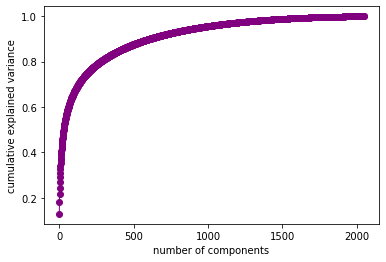

In [20]:
#Explained variance
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'ro-', linewidth=1, c='purple')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.xlim(right=400)
plt.show()

<h2>Apply PCA Feature Selection prior to MLP</h2>

In [24]:
# Standardise data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(local_features)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(local_features)

# instantiate PCA with determined dimension
pca = PCA(.90)

# fit train data to PCA
pca.fit(train_X)

#  the mapping (transform) to both the training set and the test set
train_X = pca.transform(train_X)

In [43]:
# empty df to store output of all patients
df_output = pd.DataFrame()

# Train a final model on the full training set
estimator = MLPClassifier(solver='sgd', random_state=1, hidden_layer_sizes=(30, 3), 
                          max_iter=300, early_stopping=True, n_iter_no_change=20, verbose=0, nesterovs_momentum=True)

estimator.fit(train_X, local_labels)

for f in filenames_test: 
    patient_id:str = Path(f).stem.split("ID_")[1]
    test_X = get_tile_features(f)
    
    # do the PCA transformation on test set
    test_X = scaler.transform(test_X)
    test_X = pca.transform(test_X)
    # estimate 
    preds_test = estimator.predict_proba(test_X)[:, 1]
    class_test = estimator.predict(test_X)
    
    # Check that predictions are in [0, 1]
    assert np.max(preds_test) <= 1.0
    assert np.min(preds_test) >= 0.0
    
    test_output = pd.DataFrame({"ID": patient_id, "Target": preds_test, "Category": class_test})
    df_output = df_output.append(test_output, ignore_index=True)

In [45]:
# if positive proba is absent, ie. no positive class detected for a patient
# choose negative proba. Otherwise, use positive proba
def select_final_proba(pos_proba, nega_proba):
    if np.isnan(pos_proba):
        final_proba = nega_proba
    else:
        final_proba = pos_proba
    return final_proba

In [46]:
recap = pd.pivot_table(df_output, values='Target', index=['ID'], columns=['Category'], aggfunc={'Target': np.mean})
# rename recap table
colnames = ['negative_proba', 'positive_proba']
recap.columns = colnames

# apply the function to new column of dataframe
recap['Target'] = recap.apply(lambda x: select_final_proba(x.positive_proba, x.negative_proba), axis=1)

# drop useless columns and save result to csv
output = recap.drop(columns=['negative_proba', 'positive_proba'])
output.to_csv("predictions/MLP.csv")

<h2>Annotate unlabeled positive cases</h2>

In [47]:
# retrieve all positive patient case
positive_patients = train_output[train_output['Target']==1]
positive_patients['npy_ID'] = positive_patients.apply(lambda x: f"ID_{str(x['ID']).zfill(3)}.npy", axis=1)

# store all positive case npys to an array for compilation
added_pat_list = np.array(positive_patients['npy_ID'])
added_pat_list = [f"train_input/resnet_features/{i}" for i in added_pat_list]

# Compile unlabeled positive cases in training set
posData = dataCompiler(added_pat_list)

# add new column new_tile_id
posData['new_tile_id']:str = posData.apply(lambda x: generate_new_id(x.patient_id, x.zoom_level, x.x_coord, x.y_coord),  axis = 1)

<ipython-input-47-71369531e043>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_patients['npy_ID'] = positive_patients.apply(lambda x: f"ID_{str(x['ID']).zfill(3)}.npy", axis=1)


train_input/resnet_features/ID_035.npy does not exist.
train_input/resnet_features/ID_036.npy does not exist.
train_input/resnet_features/ID_041.npy does not exist.
train_input/resnet_features/ID_046.npy does not exist.
train_input/resnet_features/ID_129.npy does not exist.
train_input/resnet_features/ID_166.npy does not exist.
train_input/resnet_features/ID_174.npy does not exist.
train_input/resnet_features/ID_218.npy does not exist.
train_input/resnet_features/ID_243.npy does not exist.
train_input/resnet_features/ID_262.npy does not exist.
train_input/resnet_features/ID_387.npy does not exist.


In [48]:
# create a training test set for prediction
added_features = np.array(posData.iloc[:, 3:2051])

<h2>Train MLP with tuned hyperparameter and predict on the added unlabeled set</h2>

In [51]:
# Standardize training and test features and apply standardization to test features
scaler = StandardScaler()
train_X = scaler.fit_transform(local_features)
test_X = scaler.transform(added_features)

# Apply PCA feature selection to both train and test set
pca = PCA(.90)
pca.fit(train_X)
train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

# Use the tile-level resnet features to predict the labels
# Create a MLP Classifier
model = MLPClassifier(solver='sgd', random_state=1, hidden_layer_sizes=(30, 3), 
                          max_iter=300, early_stopping=True, n_iter_no_change=20, verbose=0, nesterovs_momentum=True)


# Train the model using the training sets
model.fit(train_X, local_labels)

# Predict the response for test dataset
y_pred = model.predict(test_X)
y_pred_proba = model.predict_proba(test_X)

In [52]:
# recap prediction info to dataframe
recap = pd.DataFrame(data=y_pred_proba)
recap['Target'] = y_pred
recap['patient_id'] = posData['patient_id']
recap.columns = ['negative', 'positive', 'Target', 'ID']
recap_count = pd.pivot_table(recap, index=['ID'], columns=['Target'], aggfunc={'Target': 'count'})
recap_count.columns = ['NB_neg', 'NB_pos']

In [59]:
# check if patient-level data to be eliminated
eliminated = recap_count[recap_count['NB_pos'].isnull()]
print(len(eliminated)) # check if all global predictions point to positive, fitting our expectation

5


In [71]:
# create list to eliminated
eliminated.reset_index(inplace=True)
eli_list = list(eliminated['ID'])

In [80]:
# Do top scoring example selections 
# form a simulated dataset to complete the old locally annotated one 
posData['Target'] = y_pred
posData['positive_proba'] = recap['positive']
neg_examples = posData[posData['positive_proba']<0.003]
pos_examples = posData[posData['positive_proba']>=0.95]
selected_examples = pd.concat([neg_examples, pos_examples], ignore_index=True)

In [84]:
# eliminate those samples in the list from the data set
selected_examples = selected_examples[~selected_examples['patient_id'].isin(eli_list)]

# form simulated dataset from unlabeled data
simulated_features = np.array(selected_examples.iloc[:, 3:2051])
simulated_labels = selected_examples['Target'].values

# add the simulated features and labels to labelised training data
# to form a bigger training set
new_features = np.append(local_features, simulated_features, axis=0)
new_labels = np.append(local_labels, simulated_labels, axis=0)
assert new_features.shape[0] == new_labels.shape[0]

<h2>Take newly-formed dataset as input and predict on the test set</h2>

In [88]:
# Evaluate the model

# number of runs for cross-validation
num_runs = 3
# number of splits for cross-validation
num_splits = 5

# Multiple cross validations on the local feature training set
aucs = []
accuracies =[]

# Standardize training and test features and apply standardization to test features
scaler = StandardScaler()
train_X = scaler.fit_transform(new_features)

# Apply PCA feature selection to both train
pca = PCA(.90)
pca.fit(train_X)
train_X = pca.transform(train_X)

for seed in range(num_runs):
    #Create a MLP Classifier
    model = MLPClassifier(solver='sgd', random_state=1, hidden_layer_sizes=(30, 3), 
                          max_iter=300, early_stopping=True, n_iter_no_change=20, verbose=0, nesterovs_momentum=True)

    cv = sklearn.model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=train_X, y=new_labels,
                                                  cv=cv, scoring="roc_auc", verbose=1)
    accuracy = sklearn.model_selection.cross_val_score(model, X=train_X, y=new_labels,
                                                  cv=cv, scoring="accuracy", verbose=1)
    
    aucs.append(auc)
    accuracies.append(accuracy)

aucs = np.array(aucs)
accuracies = np.array(accuracies)

print("Predicting strong labels by tile-level resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))
print("Accuracy: mean {}, std {}".format(accuracies.mean(), accuracies.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Predicting strong labels by tile-level resnet
AUC: mean 0.9889318308057312, std 0.003254126053450538
Accuracy: mean 0.9922262370514939, std 0.0007461870911686421


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.4s finished


In [89]:
# predict on this model

# empty df to store output of all patients
df_output = pd.DataFrame()

# Standardize training and test features and apply standardization to test features
scaler = StandardScaler()
train_X = scaler.fit_transform(new_features)

# Apply PCA feature selection to both train
pca = PCA(.90)
pca.fit(train_X)
train_X = pca.transform(train_X)

# Use the tile-level resnet features to predict the labels
# Create a MLP Classifier
model = MLPClassifier(solver='sgd', random_state=1, hidden_layer_sizes=(30, 3), 
                          max_iter=300, early_stopping=True, n_iter_no_change=20, verbose=0, nesterovs_momentum=True)

# Train the model using the training sets
model.fit(train_X, new_labels)

for f in filenames_test: 
    patient_id:str = Path(f).stem.split("ID_")[1]
    test_X = get_tile_features(f)
    
    # do the scaler and PCA transformation on test set
    test_X = scaler.transform(test_X)
    test_X = pca.transform(test_X)
    
    # Predict the response for test dataset
    y_pred = model.predict(test_X)
    
    y_pred_proba = model.predict_proba(test_X)[:, 1] #keep only positive probability
    
    # Check that predictions are in [0, 1]
    assert np.max(y_pred_proba) <= 1.0
    assert np.min(y_pred_proba) >= 0.0
    
    test_output = pd.DataFrame({"ID": patient_id, "Target": y_pred_proba, "Category": y_pred})
    df_output = df_output.append(test_output, ignore_index=True)

In [90]:
recap = pd.pivot_table(df_output, values='Target', index=['ID'], columns=['Category'], aggfunc={'Target': np.mean})
# rename recap table
colnames = ['negative_proba', 'positive_proba']
recap.columns = colnames

In [91]:
# if positive proba is absent, ie. no positive class detected for a patient
# choose negative proba. Otherwise, use positive proba
def select_final_proba(pos_proba, nega_proba):
    if np.isnan(pos_proba):
        final_proba = nega_proba
    else:
        final_proba = pos_proba
    return final_proba

# apply the function to new column of dataframe
recap['Target'] = recap.apply(lambda x: select_final_proba(x.positive_proba, x.negative_proba), axis=1)

In [93]:
# drop useless columns and save result to csv
output = recap.drop(columns=['negative_proba', 'positive_proba'])
output.to_csv("predictions/MLP_with_simulated_labels.csv")